# Capstone Project: Hotel booking demand

To start of, we'll load some libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Then, we'll load the data

In [3]:
file = './data/hotel_bookings.csv'
df = pd.read_csv(file)
print(df.shape)

(119390, 32)


and do a first check:

In [4]:
pd.set_option("display.max_columns", 32)
display(df.head())


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Preparation

Since the dataframe still holds NaN values, those need to be filled. Following the dataset's description, the NaN values actually hold information and just need to be transformed to reflect that.

In [5]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

The country variable does not need to be filled at the time of booking, so NaN values can occur here and need to be replaced.
If an agent variable is NaN, it means that the booking was not made via an agent, which is information as well.
Similarily, if company is NaN, the booking was made by a private customer. 
The four children NaN values will be set to 0.

Additionally, in the meal column, there exist two ways to display the same information. Undefined is equal to SC, so we will need to replace Undefined with SC. 

Utilizing knowlede required at a later stage, we will also remove observations with 0 customers.

In [6]:
df = df.fillna({'agent':0, 'company':0, 'country':'None', 'children':0})
df.meal.replace('Undefined', 'SC', inplace=True)
df.drop(list(df.loc[df.adults + df.children + df.babies == 0].index), inplace=True)

In [7]:
df.shape

(119210, 32)

Additionally, certain columns are not representing the right dtypes. 
According to the authors of the [paper](https://www.sciencedirect.com/science/article/pii/S2352340918315191), where the data was published, the following variables which are not yet categorical are supposed to be categorical: 

- agent
- company


In [8]:
display(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [9]:
df = df.astype({'agent': 'object', 'company': 'object'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119210 non-null object
is_canceled                       119210 non-null int64
lead_time                         119210 non-null int64
arrival_date_year                 119210 non-null int64
arrival_date_month                119210 non-null object
arrival_date_week_number          119210 non-null int64
arrival_date_day_of_month         119210 non-null int64
stays_in_weekend_nights           119210 non-null int64
stays_in_week_nights              119210 non-null int64
adults                            119210 non-null int64
children                          119210 non-null float64
babies                            119210 non-null int64
meal                              119210 non-null object
country                           119210 non-null object
market_segment                    119210 non-null object
distribution_channel              119210 n

## Data Exploration

We'll take a closer look at the data here.

### Target Variable

First off, we'll take a univariate look at the distribution of the target variable, to get a feel for the problem statement. 

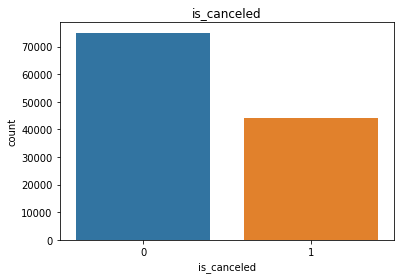

In [11]:
ax = sns.countplot('is_canceled', data = df)
ax.set_title("is_canceled")
plt.show()

### Hotel

We'll take a look at the distribution of cancelled bookings between hotels.

Text(0.5,1,'Number of Bookings by Hotel')

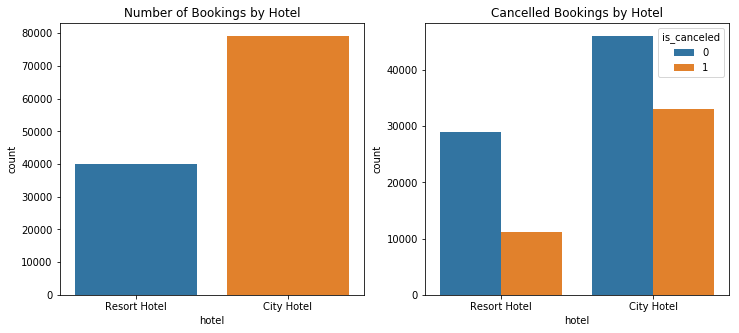

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.countplot(x = "hotel", data = df, ax = ax[0])
sns.countplot(x = "hotel", hue = "is_canceled", data = df, ax = ax[1])
ax[1].set_title("Cancelled Bookings by Hotel")
ax[0].set_title("Number of Bookings by Hotel")

In [13]:
df.groupby(['hotel', 'is_canceled'])['is_canceled'].count() / df.shape[0]

hotel         is_canceled
City Hotel    0              0.386578
              1              0.277485
Resort Hotel  0              0.242656
              1              0.093281
Name: is_canceled, dtype: float64

### Agents

Agents are difficult, because a small portion of agents manage most of the bookings. For this purpose, we might include only a few agents as categorical variables in the data, and fill the others with different values

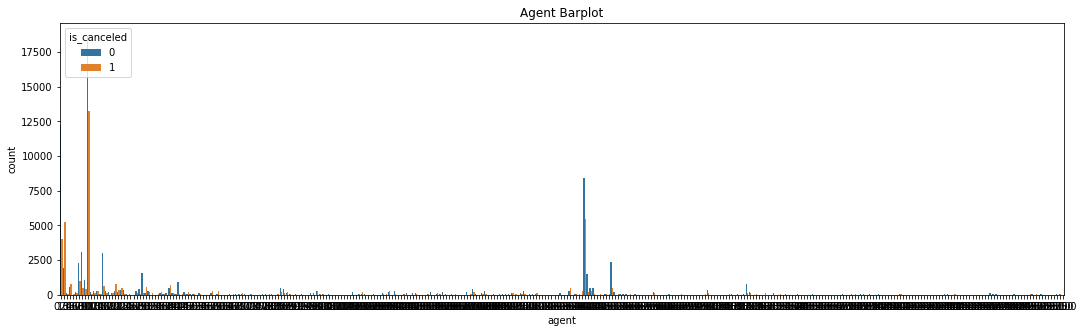

In [14]:
fig, ax = plt.subplots(1,1, figsize = (18, 5))
sns.countplot(x = 'agent', hue = 'is_canceled', data = df, ax = ax)
ax.set_title("Agent Barplot")
plt.show()

In [15]:
df.agent.describe()

count     119210.0
unique       334.0
top            9.0
freq       31922.0
Name: agent, dtype: float64

In [16]:
df.agent.value_counts(normalize=True).head(10)

9.0      0.267780
0.0      0.136566
240.0    0.116786
1.0      0.060289
14.0     0.030476
7.0      0.029628
6.0      0.027598
250.0    0.024075
241.0    0.014437
28.0     0.013900
Name: agent, dtype: float64

In [17]:
df.meal.value_counts(normalize=True)

BB    0.773727
HB    0.121282
SC    0.098297
FB    0.006694
Name: meal, dtype: float64

## Feature Engineering, Preprocessing and Selection

This section includes feature engineering and preprocessing, like one-hot encoding and removal of possible leakage variables.

Categorical Variables: 
- is_canceled (target variable) 
- hotel (one-hot encoding)
- arrival_data_month (one-hot encoding, essentially a seasonal variable)
- meal (one-hot encoding)
- country (one-hot; drop; aggregate?)
- market_segment (one-hot, possibly correlated with agent)
- distribution_channel (one-hot, little variance)
- reserved room type
- assigned room type
- deposit_type
- agent
- company (remove: ID Variable with too much noise) 
- customer_type
- reservation_status (remove: possible leakage)
- reservation_status_date (remove: possible leakage)

In [45]:
# Agent encoding
# We fill it with -99 for now. Should be fine since we one-hot encode this column later
top_eight = df.agent.value_counts(normalize=True).index.tolist()[8:]

df.replace(top_eight, -99, inplace=True)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,-99.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,-99.0,0.0,0,Transient,-99.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,-99.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,-99.0,0.0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,-99.0,0.0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [18]:
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
                "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel", "agent", "arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Modelling

In [20]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'sklearn.compose'

In [19]:
feature_set = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[feature_set]
y = df["is_canceled"]

Transforming categorical features

In [ ]:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])